# Лабораторная работа №7
### МЕТОД SSA–«ГУСЕНИЦА»
## РИ-681223 Черепанов Александр
### Вариант №19

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

import h5py

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Метод сингулярного  спектрального  анализа SSA реализуется  в  2 этапа – разложениеи группировка. 
Напишим функцию для этапа разложения, которая принимает два параметра: сам временной ряд F и длину окна разложения L.

In [27]:
def SSA_modes(F, L=3):
  # Первый шаг: Составляем траекторную матрицу
  N = len(F)
  K = N - L + 1
  X = np.column_stack([F[i:i+L] for i in range(0,K)])

  # Второй шаг: SVD
  S = np.dot(X, X.T)
  # Используем реализацию сингуляроного разложения из библиотеки numpy
  U, A, _ = np.linalg.svd(S)
  # Матрица тректорных векторов
  V = np.dot(X.T, U)
  return A, U, V

Проверим правильность и работоспособность данной функции на примере:

In [28]:
ts = np.array([3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3]) # мини временной ряд
A, U, V = SSA_modes(ts, 3) # его разложение с длиной окна = 3

print(A) #собственные числа
print(U) #собственные вектора
print(V) #траекторные вектора

[129.66842566  12.           3.33157434]
[[-5.78869570e-01  7.07106781e-01  4.06091149e-01]
 [-5.74299610e-01  4.14039445e-16 -8.18645196e-01]
 [-5.78869570e-01 -7.07106781e-01  4.06091149e-01]]
[[-3.46407750e+00  1.41421356e+00 -1.29257973e-02]
 [-2.88977789e+00  0.00000000e+00  8.05719399e-01]
 [-3.46407750e+00 -1.41421356e+00 -1.29257973e-02]
 [-4.03837711e+00  8.88178420e-16 -8.31570994e-01]
 [-3.46407750e+00  1.41421356e+00 -1.29257973e-02]
 [-2.88977789e+00  0.00000000e+00  8.05719399e-01]
 [-3.46407750e+00 -1.41421356e+00 -1.29257973e-02]
 [-4.03837711e+00  8.88178420e-16 -8.31570994e-01]
 [-3.46407750e+00  1.41421356e+00 -1.29257973e-02]
 [-2.88977789e+00  0.00000000e+00  8.05719399e-01]
 [-3.46407750e+00 -1.41421356e+00 -1.29257973e-02]]


Функция реализована корректно

Напишим функцию, которая  будет  реализовывать  этап восстановления ряда.Входными  параметрами  являются  массив  собственных  значений A, массив  собственных  векторов U,  массив  траекторных  векторов V, длина ряда N и массив группировки компонент I. Выходной параметр всего   один – это   массив,   который   содержит   отсчеты восстановленного ряда.

In [29]:
def SSA_group(A, U, V, N, I, L=3):
  K = N - L + 1
  # Шаг группировки
  V = V.transpose()
  Z = np.dot(U[:, I], V[I, :])
  # Шаг диагонального  усреднения
  G = np.zeros(N)
  Ll = min(L, K)
  Kk = max(L, K)

  gs1 = [1/(k + 1) * sum([Z[m, k - m] for m in range(0, k + 1)]) 
                                  for k in range(0, Ll - 1)]

  gs2 = [1/Ll * sum([Z[m, k - m] for m in range(0, Ll)]) 
                               for k in range(Ll - 1, Kk)]

  gs3 = [1/(N - k) * sum([Z[m, k - m] for m in range(k - Kk + 1, N - Kk + 1)]) 
                                  for k in range(Kk, N)]
  return np.array(gs1 + gs2 + gs3)

Проверим работоспособность функции SSA_group:

In [30]:
ts1 = SSA_group(A, U, V, len(ts), [0, 1, 2])
print(ts1)

[3. 2. 1. 2. 3. 2. 1. 2. 3. 2. 1. 2. 3.]


Функция реализована корректно

Построим каждую  компоненту  отдельно  (массив  группировки [0], затем [1],затем[2]),  и  их  попарные  комбинации  ([0,   1],   [0,   2],   [1,   2]). Изобразим их на рисунках относительно исходного временного ряда. 

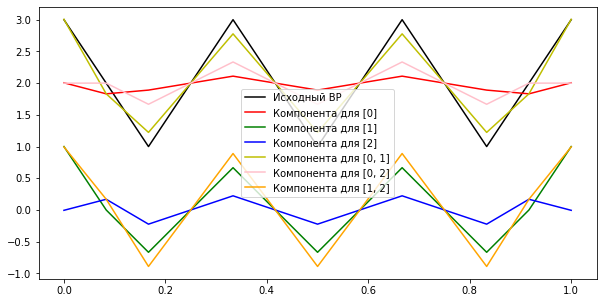

In [31]:
ts0 =  SSA_group(A, U, V, len(ts), [0])
ts1 =  SSA_group(A, U, V, len(ts), [1])
ts2 =  SSA_group(A, U, V, len(ts), [2])
ts01 = SSA_group(A, U, V, len(ts), [0, 1])
ts02 = SSA_group(A, U, V, len(ts), [0, 2])
ts12 = SSA_group(A, U, V, len(ts), [1, 2])

t = np.linspace(0, 1, len(ts))
plt.figure(figsize = (10, 5))
plt.plot(t, ts, 'k', label='Исходный ВР')
plt.plot(t, ts0, 'r', label='Компонента для [0]')
plt.plot(t, ts1, 'g', label='Компонента для [1]')
plt.plot(t, ts2, 'b', label='Компонента для [2]')
plt.plot(t, ts01, 'y', label='Компонента для [0, 1]')
plt.plot(t, ts02, 'pink', label='Компонента для [0, 2]')
plt.plot(t, ts12, 'orange', label='Компонента для [1, 2]')
plt.legend()
plt.show()

Во-первых,  0-компонента  содержит  некоторое  среднее плавающее  значение  ряда (тренд),  а  уже  1-компонента  и  2-компонента имеют среднее значение близкое к нулю. Во-вторых, 1-компонента  и  2-компонента  имеют  одинаковый  период,  так  как любая периодическая составляющая методом SSA всегда разлагается на  парные  компоненты. В-третьих,  амплитуда  1-компоненты  выше амплитуды  2-компоненты,  так  как  массив  собственных  чисел упорядочен  по  убыванию,  то  есть  с  ростом  номера  компоненты  ее «вклад» в исходный ряд уменьшается.

Построим модельный ряд из 2 периодик с шумом, где черным изобразится модельный ряд с шумом, синим – первая периодика, красным – вторая периодика:

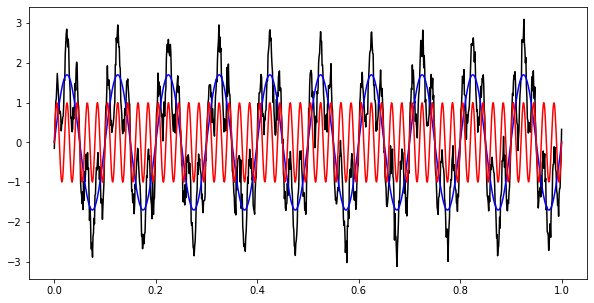

In [32]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 50
F = 1.7 * np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + 0.2*rand.randn(len(t))

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, 1.7 * np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r')
plt.show()

Выделим с  помощью  метода SSA компоненты, наиболее близкие к исходным периодикам в модельном ряде.

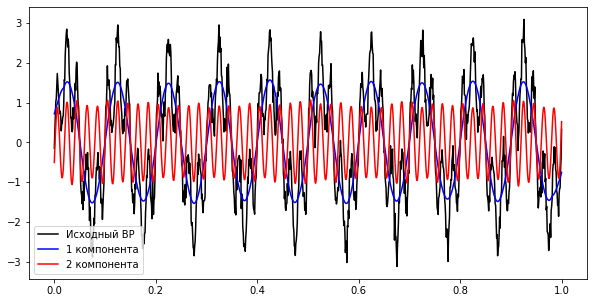

In [33]:
L = 20
A, U, V = SSA_modes(F, L)
ts0 = SSA_group(A, U, V, len(F), [0], L)
ts1 = SSA_group(A, U, V, len(F), [2, 2], L)

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k', label='Исходный ВР')
plt.plot(t, ts0, 'b', label='1 компонента')
plt.plot(t, ts1, 'r', label='2 компонента')
plt.legend()
plt.show()

Аналогичной методикой построим тренд для сильно зашумленного ВР. Пусть задан ВР:

In [34]:
t = np.linspace(0,4,4096)
F = np.exp(-0.4*np.pi*t) + 0.5*rand.randn(len(t))

Используя метод SSA выделим экспоненциальный тренд

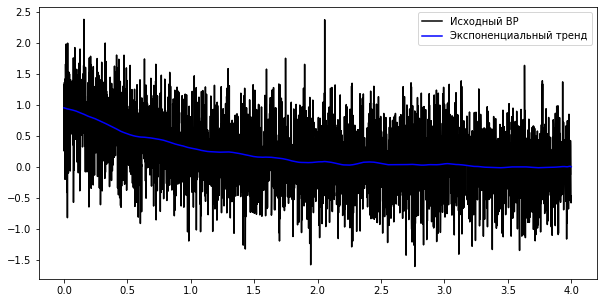

In [35]:
L = 200
A, U, V = SSA_modes(F, L)
ts0 = SSA_group(A, U, V, len(F), [0], L)

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k', label='Исходный ВР')
plt.plot(t, ts0, 'b', label='Экспоненциальный тренд')
plt.legend()
plt.show()

Создадим периодический сигнал с изломом частоты:

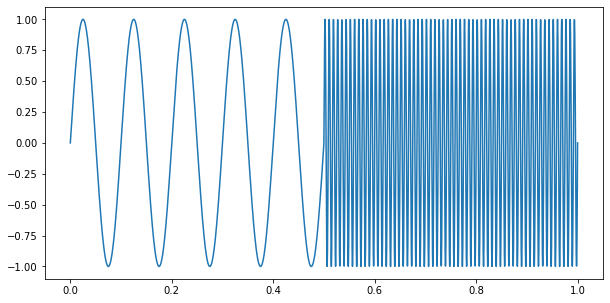

In [36]:
t = np.linspace(0, 1, 4096)
x2 = np.zeros(4096)

for i in range(0, len(t)//2):
  x2[i] = np.sin(2*np.pi*10*t[i])    
for i in range(len(t)//2, len(t)):
  x2[i] = np.sin(2*np.pi*120*t[i])
  
plt.figure(figsize = (10, 5))
plt.plot(t, x2)
plt.show()

Выделим компоненты,  наиболее  близкие  к  исходным  периодикам на двух половинках временного интервала в модельном ряде:

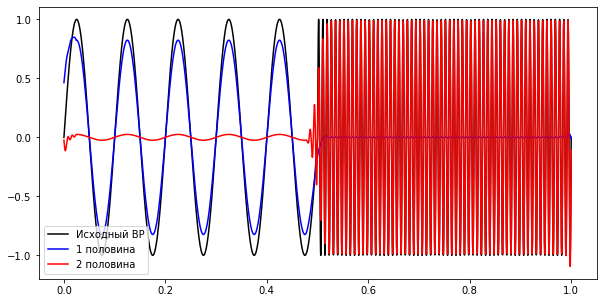

In [37]:
L = 100
A, U, V = SSA_modes(x2, L)
ts0 = SSA_group(A, U, V, len(x2), [0], L)
ts1 = SSA_group(A, U, V, len(x2), [1, 2], L)

plt.figure(figsize = (10, 5))
plt.plot(t, x2, 'k', label='Исходный ВР')
plt.plot(t, ts0, 'b', label='1 половина')
plt.plot(t, ts1, 'r', label='2 половина')
plt.legend()
plt.show()

Смоделируем временной  ряд из 4 гармоник  с  шумом,  и разделим его на компоненты с помощью метода SSA:

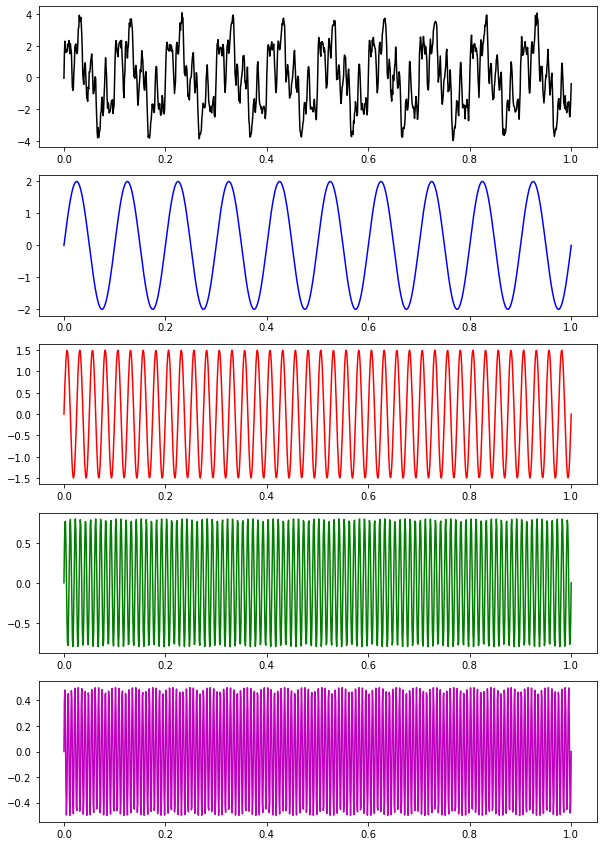

In [38]:
t = np.linspace(0,1,1024)
f1 = 10
f2 = 40
f3 = 100
f4 = 150
F = 2.0*np.sin(2*np.pi*f1*t) + 1.5*np.sin(2*np.pi*f2*t) + 0.8*np.sin(2*np.pi*f3*t) + 0.5*np.sin(2*np.pi*f4*t) + 0.2*rand.randn(len(t))

plt.figure(figsize = (10, 15))
plt.subplot(5,1,1)
plt.plot(t, F, 'k')
plt.subplot(5,1,2)
plt.plot(t, 2.0*np.sin(2*np.pi*f1*t), 'b')
plt.subplot(5,1,3)
plt.plot(t, 1.5*np.sin(2*np.pi*f2*t), 'r')
plt.subplot(5,1,4)
plt.plot(t, 0.8*np.sin(2*np.pi*f3*t), 'g')
plt.subplot(5,1,5)
plt.plot(t, 0.5*np.sin(2*np.pi*f4*t), 'm')
plt.show()

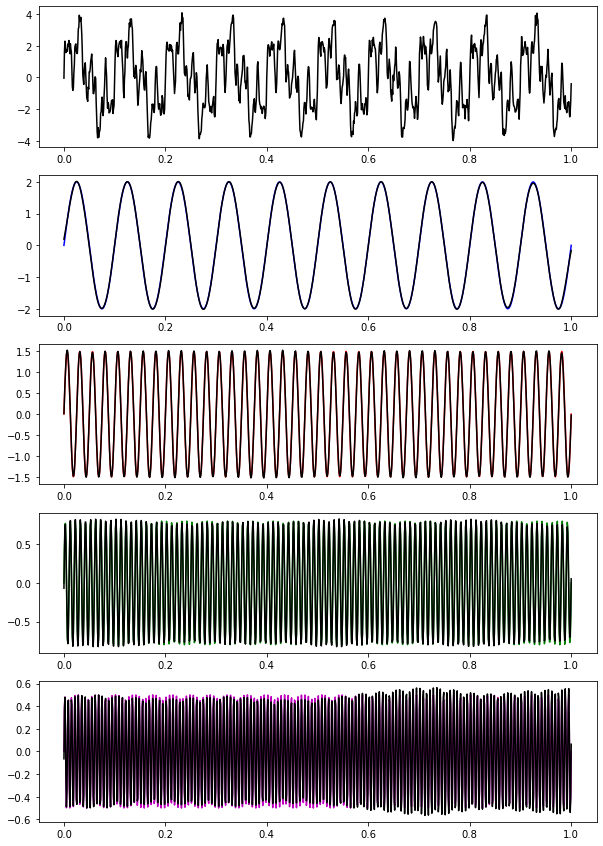

In [39]:
L = 100
A, U, V = SSA_modes(F, L)
ts0 = SSA_group(A, U, V, len(F), [0, 1], L)
ts1 = SSA_group(A, U, V, len(F), [2, 3], L)
ts2 = SSA_group(A, U, V, len(F), [4, 5], L)
ts3 = SSA_group(A, U, V, len(F), [6, 7], L)

plt.figure(figsize = (10, 15))
plt.subplot(5,1,1)
plt.plot(t, F, 'k')
plt.subplot(5,1,2)
plt.plot(t, 2.0*np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, ts0, 'black')
plt.subplot(5,1,3)
plt.plot(t, 1.5*np.sin(2*np.pi*f2*t), 'r')
plt.plot(t, ts1, 'black')
plt.subplot(5,1,4)
plt.plot(t, 0.8*np.sin(2*np.pi*f3*t), 'g')
plt.plot(t, ts2, 'black')
plt.subplot(5,1,5)
plt.plot(t, 0.5*np.sin(2*np.pi*f4*t), 'm')
plt.plot(t, ts3, 'black')
plt.show()

Теперь  на  основе  метода SSA реализуем прогноз временных рядов. Сначала вычислим норму последнего вектора из матрицы U для заданной группировки компонент:

In [40]:
def SSA_R(M, A, U, V, N, I, L=3):
  vu = np.linalg.norm(U[-1, I])
  # Ряд весовых коэффициентов
  R = np.sum(U[L-1, I] * U[0:L-1, I], 1)
  R = R / (1 - vu*vu)
  G = SSA_group(A, U, V, N, I, L)
  Q = np.zeros(N + M - 1)
  Q[:N] = G

  for i in range(N, N + M - 1):
    Q[i] = sum([R[-j-1]*Q[i-j-1] for j in range(0, L - 2)])

  return Q

Снова построим модельный ряд из 2 периодик с шумом:


In [41]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 50
F = 1.7 * np.sin(2*np.pi*f1*t) + np.sin(2*np.pi*f2*t) + 0.2*rand.randn(len(t))

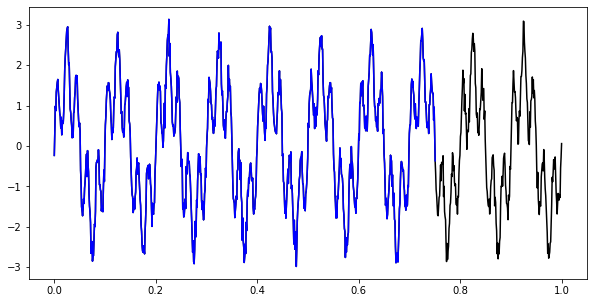

In [42]:
Z = F[:len(F)-256+1] # отрезаем последние 256 точек

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k') # исходный ВР
plt.plot(t[:len(F)-256+1], Z, 'b') # урезанный ряд
plt.show()

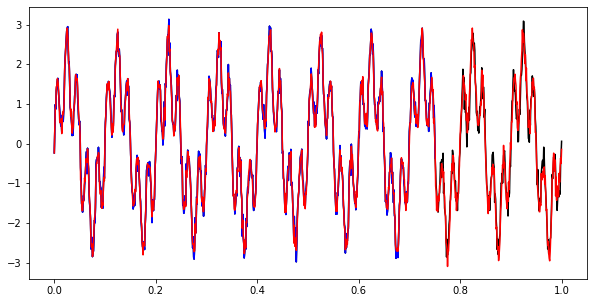

In [43]:
L = 300
M = 256
A, U, V = SSA_modes(Z, L)
tsr = SSA_R(M, A, U, V, len(Z), [i for i in range(L-200)], L)
# t0 = np.arange(0, t.shape[0] + M, 1)

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k') # исходный ВР
plt.plot(t[:len(F)-256+1], Z, 'b') # урезанный ряд
plt.plot(t, tsr, 'r') # предсказанный ряд
plt.show()

Можно заметить, что параметры длины окна и массива группировки для высокой точности декомпозиции и прогноза, отличаются. Если для достижения высокой точности декомпозиции массив группировки должен быть вида [0, 1, ... L-1], то для прогноза форма массива будет отличаться.

Постройте прогноз методом SSA-R для ряда из 4 гармоник  с  шумом на 256 точек  вперед,  подберем  для  него  наилучшие  параметры:

In [44]:
t = np.linspace(0,1,1024)
f1 = 10
f2 = 40
f3 = 100
f4 = 150
F = 2.0*np.sin(2*np.pi*f1*t) + 1.5*np.sin(2*np.pi*f2*t) + 0.8*np.sin(2*np.pi*f3*t) + 0.5*np.sin(2*np.pi*f4*t) + 0.2*rand.randn(len(t))

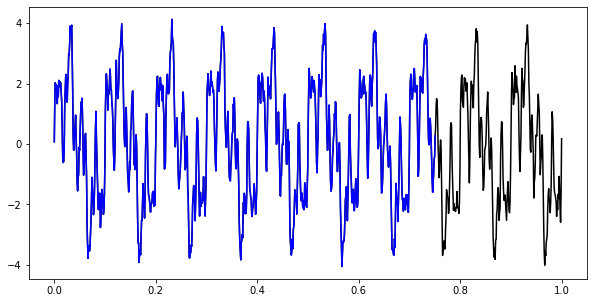

In [45]:
Z = F[:len(F)-256+1] # отрезаем последние 256 точек

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k') # исходный ВР
plt.plot(t[:len(F)-256+1], Z, 'b') # урезанный ряд
plt.show()

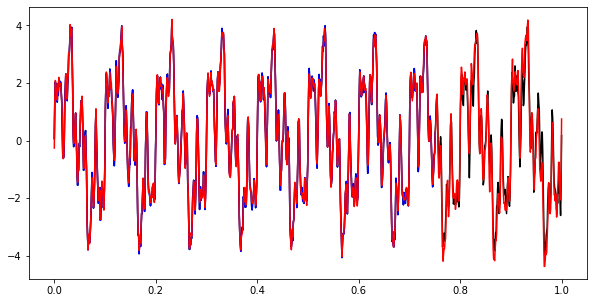

In [46]:
L = 300
M = 256
A, U, V = SSA_modes(Z, L)
tsr = SSA_R(M, A, U, V, len(Z), [i for i in range(L-200)], L)

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k') # исходный ВР
plt.plot(t[:len(F)-256+1], Z, 'b') # урезанный ряд
plt.plot(t, tsr, 'r') # предсказанный ряд
plt.show()

Полученные параметры для прогноза значительно отличаются от тех, что были при декомпозиции.

Загрузим  из  mat-файла Fort.mat ряд,  содержащий  отсчеты некоторого реального ВР, всего 174 отсчета в вектор-строке:

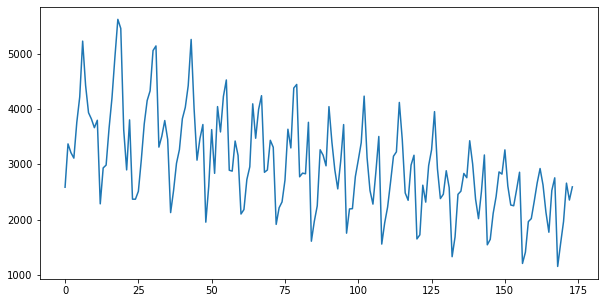

In [47]:
file = h5py.File('Fort.mat','r')
data = file.get('Fort')
fort = np.array(data)
F = np.ravel(fort)

plt.figure(figsize = (10, 5))
plt.plot(F)
plt.show()

Построим  его ретроспективный  прогноз методом SSA-R.

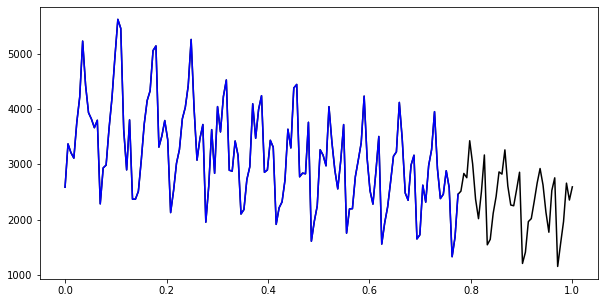

In [48]:
Z = F[:len(F)-40+1] # отрезаем последние 40 точек
t = np.linspace(0, 1, len(F))


plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k') # исходный ВР
plt.plot(t[:len(F)-40+1], Z, 'b') # урезанный ряд
plt.show()

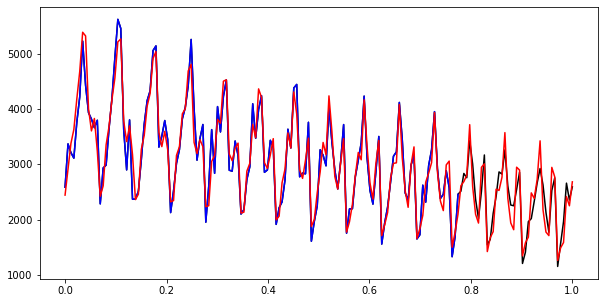

In [49]:
L = 50
M = 40
A, U, V = SSA_modes(Z, L)
tsr = SSA_R(M, A, U, V, len(Z), [i for i in range(10)], L)

plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k') # исходный ВР
plt.plot(t[:len(F)-40+1], Z, 'b') # урезанный ряд
plt.plot(t, tsr, 'r') # предсказанный ряд
plt.show()

Реализуем метод прогноза на основе SSA с итерационной аппроксимацией

In [50]:
def SSA_R_stochastic(M, F, L, I, eps=1e-3, max_iterations=1e3):
    for i in range(M):
        Fn = np.append(F, np.random.choice(F))
        for iteration in range(int(max_iterations)):
          F_last = Fn[len(Fn)-1]
          A, U, V = SSA_modes(Fn, L)
          G = SSA_group(A, U, V, len(Fn), I, L)
          Fn[len(Fn)-1] = G[len(Fn)-1]
          if (abs(Fn[-1] - F_last) < eps):
            break
        F = Fn
    return F

И построим ретроспективный прогноз  данным  методом  для  ряда Fort:

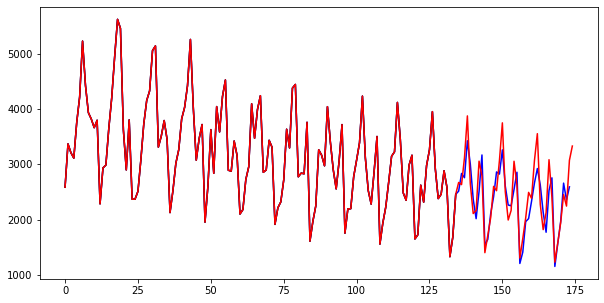

In [51]:
L = 45
M = 40
tsr = SSA_R_stochastic(M, Z, L, [i for i in range(8)])

plt.figure(figsize = (10, 5))
plt.plot(F, 'b')
plt.plot(Z, 'k')
plt.plot(tsr, 'r')
plt.show()